# Tutorial 6: Classification

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Recognize situations where a simple classifier would be appropriate for making predictions.
* Explain the k-nearest neighbour classification algorithm.
* Interpret the output of a classifier.
* Compute, by hand, the distance between points when there are two explanatory variables/predictors.
* Describe what a training data set is and how it is used in classification.
* In a dataset with two explanatory variables/predictors, perform k-nearest neighbour classification in R using `tidymodels` to predict the class of a single new observation.

This worksheet covers parts of [the Classification I chapter](https://datasciencebook.ca/classification1.html) of the online textbook. You should read this chapter before attempting the worksheet.

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Question 0.1** Multiple Choice: 
<br> {points: 1}

Before applying k-nearest neighbour to a classification task, we need to scale the data. What is the purpose of this step?

A. To help speed up the knn algorithm. 

B. To convert all data observations to numeric values. 

C. To ensure all data observations will be on a comparable scale and contribute equal shares to the calculation of the distance between points.

D. None of the above. 

*Assign your answer to an object called `answer0.1`. Make sure the correct answer is an uppercase letter. Surround your answer with quotation marks (e.g. `"F"`).*

*Note: we typically **standardize** (i.e., scale **and** center) the data before doing classification. For the K-nearest neighbour algorithm specifically, centering has no effect. But it doesn't hurt, and can help with other predictive data analyses, so we will do it below.*

In [4]:
answer0.1 <- "C"

In [5]:
test_0.1()

Test passed 🥳
[1] "Success!"


## 1. Fruit Data Example 

In the agricultural industry, cleaning, sorting, grading, and packaging food products are all necessary tasks in the post-harvest process. Products are classified based on appearance, size and shape, attributes which helps determine the quality of the food. Sorting can be done by humans, but it is tedious and time consuming. Automatic sorting could help save time and money. Images of the food products are captured and analysed to determine visual characteristics. 

The [dataset](https://www.kaggle.com/mjamilmoughal/k-nearest-neighbor-classifier-to-predict-fruits/notebook) contains observations of fruit described with four features 1) mass (in g) 2) width (in cm) 3) height (in cm) and 4) color score (on a scale from 0 - 1).

**Question 1.0** 
<br> {points: 1}

Load the file, `fruit_data.csv`, into your notebook. 

`mutate()` the `fruit_name` column such that it is a *factor* using the `as_factor()` function.

*Assign your data to an object called `fruit_data`.*

In [6]:
fruit_data <- read_csv("data/fruit_data.csv")
fruit_data <- mutate(fruit_data,
                fruit_name = as_factor(fruit_name))

Rows: 59 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): fruit_name, fruit_subtype
dbl (5): fruit_label, mass, width, height, color_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
test_1.0()

Test passed 🎉
Test passed 🥳
Test passed 🎉
Test passed 🎉
Test passed 😸
[1] "Success!"


Let's take a look at the first few observations in the fruit dataset. Run the cell below.

In [8]:
# Run this cell. 
fruit_data

fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,apple,granny_smith,192,8.4,7.3,0.55
1,apple,granny_smith,180,8.0,6.8,0.59
1,apple,granny_smith,176,7.4,7.2,0.60
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,lemon,unknown,116,5.9,8.1,0.73
4,lemon,unknown,152,6.5,8.5,0.72
4,lemon,unknown,118,6.1,8.1,0.70


**Question 1.0.1** Multiple Choice:
<br> {points: 1}

**Which of the columns should we treat as categorical variables?**

A. Fruit label, width, fruit subtype

B. Fruit name, color score, height

C. Fruit label, fruit subtype, fruit name

D. Color score, mass, width 

*Assign your answer to an object called `answer1.0.1`. Make sure the correct answer is an uppercase letter. Remember to surround your answer with quotation marks (e.g. `"E"`).*

In [9]:
answer1.0.1 <- "C"

In [10]:
test_1.0.1()

Test passed 🥇
[1] "Success!"


Run the cell below, and find the nearest neighbour based on mass and width to the first observation just by looking at the scatterplot (the first observation has been circled for you).

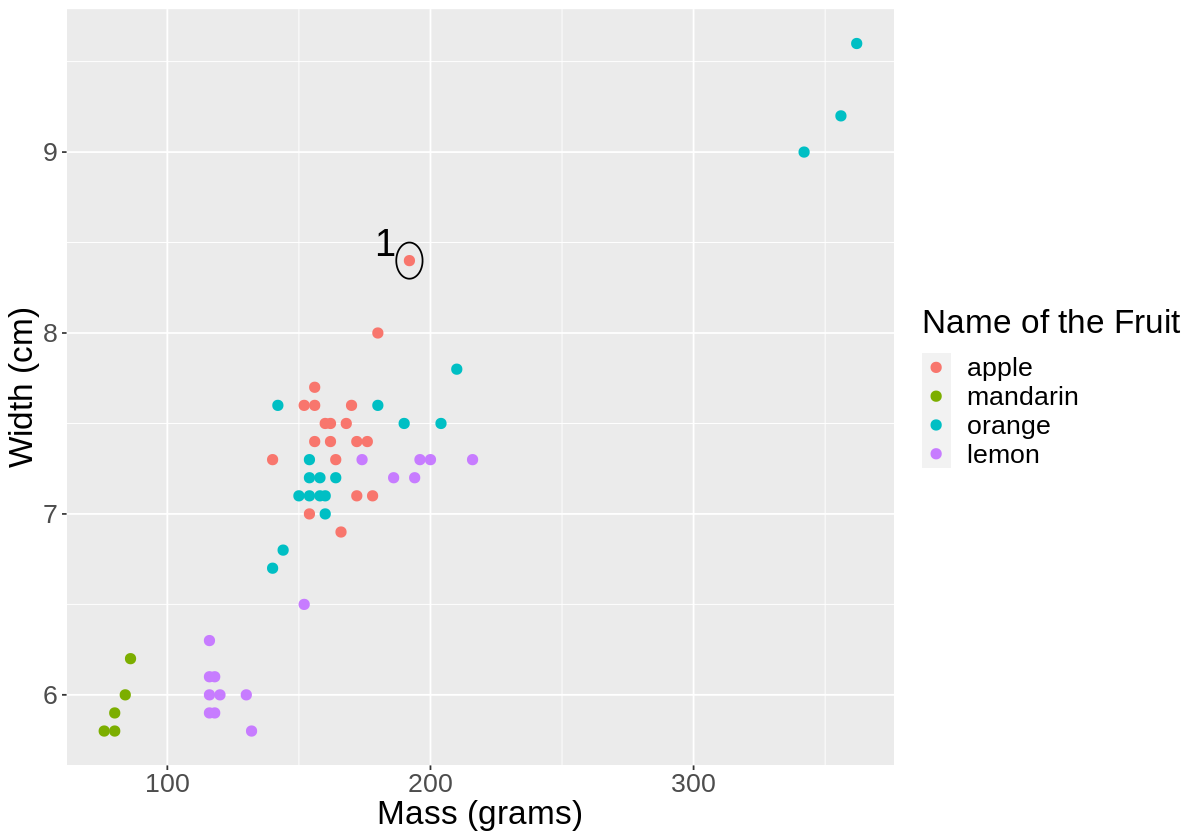

In [11]:
# Run this cell. 
options(repr.plot.width=10, repr.plot.height=7)
point1 <- c(192, 8.4)
point2 <- c(180, 8)
point44 <- c(194, 7.2)

fruit_data |>  
    ggplot(aes(x=mass, 
               y= width, 
               colour = fruit_name)) +
        labs(x = "Mass (grams)",
             y = "Width (cm)",
            colour = 'Name of the Fruit') +
        geom_point(size = 2.5) +
        annotate("path", 
                 x=point1[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point1[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 183, y =  8.5, label = "1", size = 8) + 
        theme(text = element_text(size = 20))

**Question 1.1** Multiple Choice: 
<br> {points: 1}

Based on the graph generated, what is the `fruit_name` of the closest data point to the one circled?

A. apple

B. lemon

C. mandarin 

D. orange

*Assign your answer to an object called `answer1.1`. Make sure the correct answer is an uppercase letter. Surround your answer with quotation marks (e.g. `"F"`).*

In [12]:
answer1.1 <- "A"

In [13]:
test_1.1()

Test passed 🥳
[1] "Success!"


**Question 1.2**
<br> {points: 1}

Using mass and width, calculate the distance between the first observation and the second observation. 

We provide a scaffolding to get you started. 

*Assign your answer to an object called `fruit_dist_2`.*

In [15]:
fruit_dist_2 <- fruit_data |>
    slice(1, 2) |> # We use slice to get the first two rows of the fruit dataset
    select(mass, width) |>
    dist()

fruit_dist_2

         1
2 12.00666

In [16]:
test_1.2()

Test passed 😸
Test passed 🥇
[1] "Success!"


**Question 1.3**
<br> {points: 1}

Calculate the distance between the first and the the 44th observation in the fruit dataset using the mass and width variables. 

*Assign your answer to an object called `fruit_dist_44`.*

In [17]:
fruit_dist_44 <- fruit_data |>
    slice(1, 44) |> # We use slice to get the first two rows of the fruit dataset
    select(mass, width) |>
    dist()

fruit_dist_44

         1
2 2.332381

In [18]:
test_1.3()

Test passed 😀
Test passed 🎉
[1] "Success!"


Let's circle these three observations on the plot from earlier.


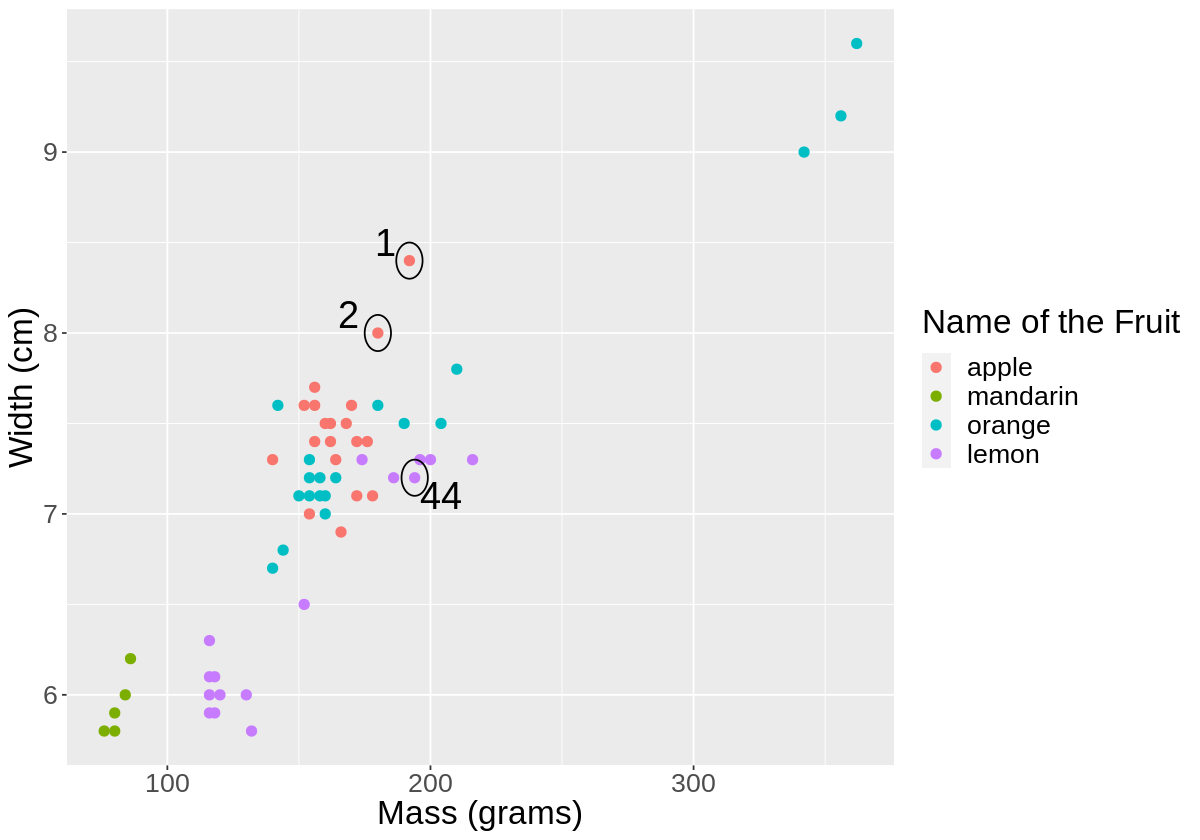

In [19]:
options(repr.plot.width = 10, repr.plot.height = 7)

# Run this cell. 
point1 <- c(192, 8.4)
point2 <- c(180, 8)
point44 <- c(194, 7.2)

fruit_data |>
    ggplot(aes(x = mass, 
               y = width, 
               colour = fruit_name)) +
        labs(x = "Mass (grams)",
             y = "Width (cm)",
            colour = 'Name of the Fruit') +
        geom_point(size = 2.5) +
        theme(text = element_text(size = 20)) +
        annotate("path", 
                 x=point1[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point1[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 183, y =  8.5, label = "1", size = 8) +
        annotate("path",
                 x=point2[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point2[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 169, y =  8.1, label = "2", size = 8) +
        annotate("path",
                 x=point44[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point44[2]+0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 204, y =  7.1, label = "44", size = 8) 

What do you notice about your answers from **Question 1.2 & 1.3** that you just calculated? Is it what you would expect given the scatter plot above? Why or why not? Discuss with your neighbour. 

*Hint: Look at where the observations are on the scatterplot in the cell above this question, and what might happen if we changed grams into kilograms to measure the mass?*


**Question 1.4** Multiple Choice:
<br> {points: 1}

The distance between the first and second observation is 12.01 and the distance between the first and 44th observation is 2.33. By the formula, observation 1 and 44 are closer, however, if we look at the scatterplot the distance of the first observation to the second observation appears closer than to the 44th observation. 

Which of the following statements is correct?

A. A difference of 12 g in mass between observation 1 and 2 is large compared to a difference of 1.2 cm in width between observation 1 and 44. Consequently, mass will drive the classification results, and width will have less of an effect. 

B. If we measured mass in kilograms, then we’d get different nearest neighbours.

C. We should standardize the data so that all variables will be on a comparable scale. 

D. All of the above. 

*Assign your answer to an object called `answer1.4`. Make sure the correct answer is an uppercase letter. Surround your answer with quotation marks (e.g. `"F"`).*

In [22]:
answer1.4 <- "D"

In [23]:
test_1.4()

Test passed 😸
[1] "Success!"


**Question 1.5**
<br> {points: 1}

Let's create a `tidymodels` recipe to *standardize* (i.e., center and scale) all of the variables in the fruit dataset. Centering will make sure that every variable has an average of 0, and scaling will make sure that every variable has standard deviation of 1. We will use the `step_scale` and `step_center` preprocessing steps in the recipe. Then `bake` the recipe so that we can examine the output.

Specify your recipe with class variable `fruit_name` and predictors `mass`, `width`, `height`, and `color_score`. 

Name the recipe `fruit_data_recipe`, and name the preprocessed data `fruit_data_scaled`.

In [26]:
# Set the seed. Don't remove this!
set.seed(9999) 

fruit_data_recipe <- recipe(fruit_name ~ mass + width + height + color_score, data = fruit_data) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

fruit_data_scaled <- fruit_data_recipe |>  
                            prep() |> 
                            bake(fruit_data)


fruit_data_scaled

mass,width,height,color_score,fruit_name
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.5249358,1.5850841,-0.2889166,-2.769820,apple
0.3068287,1.0954508,-0.6562889,-2.249376,apple
0.2341263,0.3610008,-0.3623910,-2.119265,apple
⋮,⋮,⋮,⋮,⋮
-0.8564094,-1.4751241,0.2988792,-0.4278225,lemon
-0.2020880,-0.7406741,0.5927771,-0.5579334,lemon
-0.8200582,-1.2303074,0.2988792,-0.8181553,lemon


In [27]:
test_1.5()

Test passed 🌈
Test passed 😀
Test passed 🥳
Test passed 😸
Test passed 🌈
Test passed 😀
Test passed 😸
[1] "Success!"


**Question 1.6**
<br> {points: 1}

Let's repeat **Question 1.2 and 1.3** with the scaled variables:

- calculate the distance with the scaled mass and width variables between observations 1 and 2
- calculate the distances with the scaled mass and width variables between observations 1 and 44 

After you do this, think about how these distances compared to the distances you computed in **Question 1.2 and 1.3** for the same points.

*Assign your answers to objects called `distance_2` and `distance_44` respectively.*

In [32]:
distance_2 <- fruit_data_scaled |>
    slice(1, 2) |> # We use slice to get the first two rows of the fruit dataset
    select(mass, width) |>
    dist()

distance_44 <- fruit_data_scaled |>
    slice(1, 44) |> # We use slice to get the first two rows of the fruit dataset
    select(mass, width) |>
    dist()

distance_2
distance_44

          1
2 0.5360145

        1
2 1.46935

In [33]:
test_1.6()

Test passed 🎊
Test passed 🥇
Test passed 🎉
Test passed 🎉
Test passed 😀
Test passed 😸
[1] "Success!"


**Question 1.7**
<br> {points: 1}

Make a scatterplot of scaled mass on the horizontal axis and scaled color score on the vertical axis. Color the points by fruit name. 

*Assign your plot to an object called `fruit_plot`. Make sure to do all the things to make an effective visualization.*

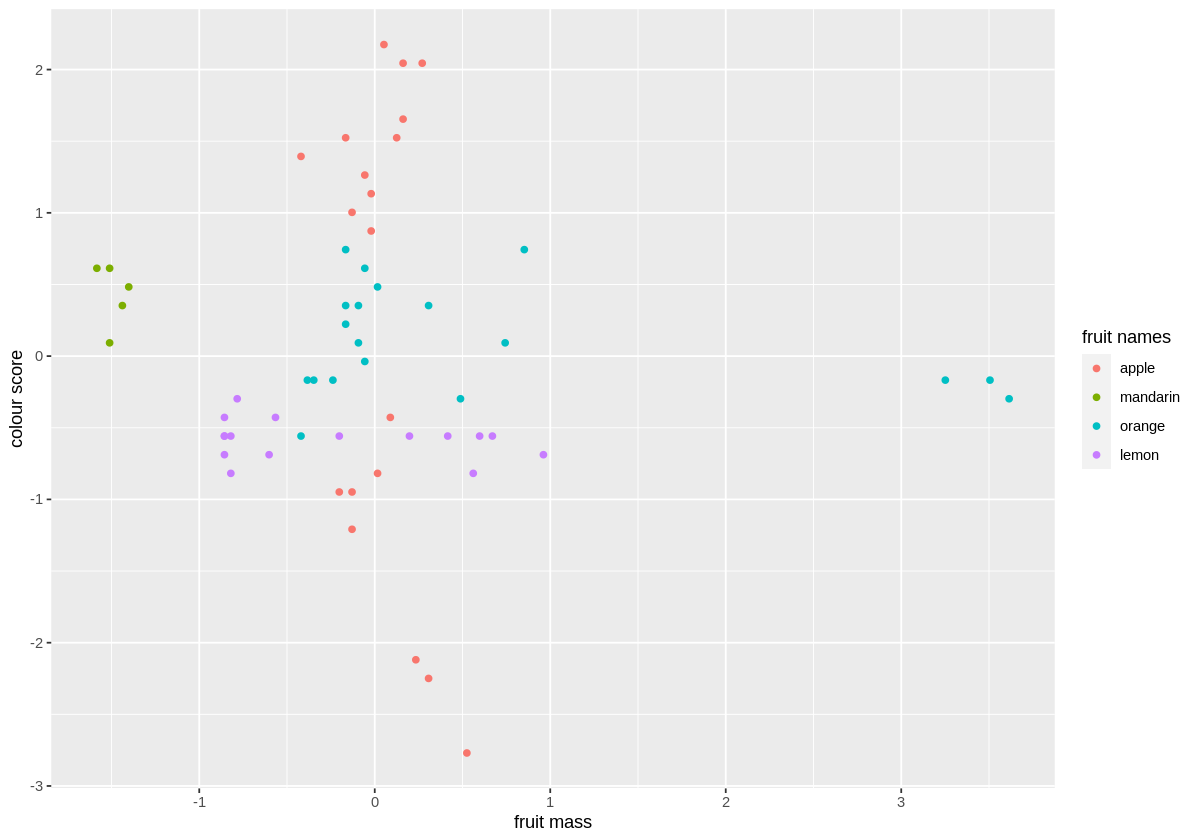

In [41]:
fruit_plot <- fruit_data_scaled |>
    ggplot(aes(x = mass, y = color_score, color = fruit_name)) +
    geom_point() + 
    xlab("fruit mass") + 
    ylab("colour score") + 
    labs(color = "fruit names")

fruit_plot


In [42]:
test_1.7()

Test passed 🌈
Test passed 😸
Test passed 🎊
Test passed 😀
Test passed 😀
Test passed 🎉
[1] "Success!"


**Question 1.8** 
<br> {points: 3}

Suppose we have a new observation in the fruit dataset with scaled mass 0.5 and scaled color score 0.5.

Just by looking at the scatterplot, how would you classify this observation using K-nearest neighbours if you use K = 3? Explain how you arrived at your answer.

I would classify it as an orange given that that VISUALLY checking the plot the closet approximate points are of the class orange 


**Question 1.9**
<br> {points: 1}

Now, let's use the `tidymodels` package to predict `fruit_name` for another new observation. The new observation we are interested in has mass 150g and color score 0.73.

First, create the K-nearest neighbour model specification. Specify that we want $K=5$ neighbors, `set_engine` to be `"kknn"`, and that each neighboring point should have the same weight when voting. Name this model specification as `knn_spec`.

Then create a new recipe named `fruit_data_recipe_2` that centers and scales the predictors, but only uses `mass` and `color_score` as predictors.

Combine this with your recipe from before in a `workflow`, and fit to the `fruit_data` dataset. 

Name the fitted model `fruit_fit`.

In [54]:
# Set the seed. Don't remove this!
set.seed(9999) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

fruit_data_recipe_2 <- recipe(fruit_name ~ mass + color_score, data = fruit_data) |>                        step_scale(all_predictors()) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

fruit_fit <- workflow() |>
          add_recipe(fruit_data_recipe_2) |>
          add_model(knn_spec) |>
          fit(data = fruit_data)


In [49]:
test_1.9()

Test passed 🌈
Test passed 😀
Test passed 😸
Test passed 🥳
Test passed 🎉
Test passed 🎉
Test passed 😸
Test passed 😸
Test passed 🌈
Test passed 🎊
[1] "Success!"


**Question 1.10**
<br> {points: 1}

Create a new tibble where `mass = 150` and `color_score = 0.73` and call it `new_fruit`. Then, pass `fruit_fit` and `new_fruit` to the `predict` function to predict the class for the new fruit observation. Save your prediction to an object named `fruit_predicted`.

In [50]:
new_fruit <- tibble(mass = 150, color_score = 0.73)
fruit_predicted <- predict(fruit_fit, new_fruit)

fruit_predicted

.pred_class
<fct>
orange


In [51]:
test_1.10()

Test passed 🌈
Test passed 🎊
Test passed 🥇
[1] "Success!"


**Question 1.11** 
<br> {points: 3}

Revisiting `fruit_plot` and considering the prediction given by K-nearest neighbours above, do you think the classification model did a "good" job predicting? Could you have done/do better? Given what we know this far in the course, what might we want to do to help with tricky prediction cases such as this?

*You can use the code below to visualize the observation whose label we just tried to predict.*

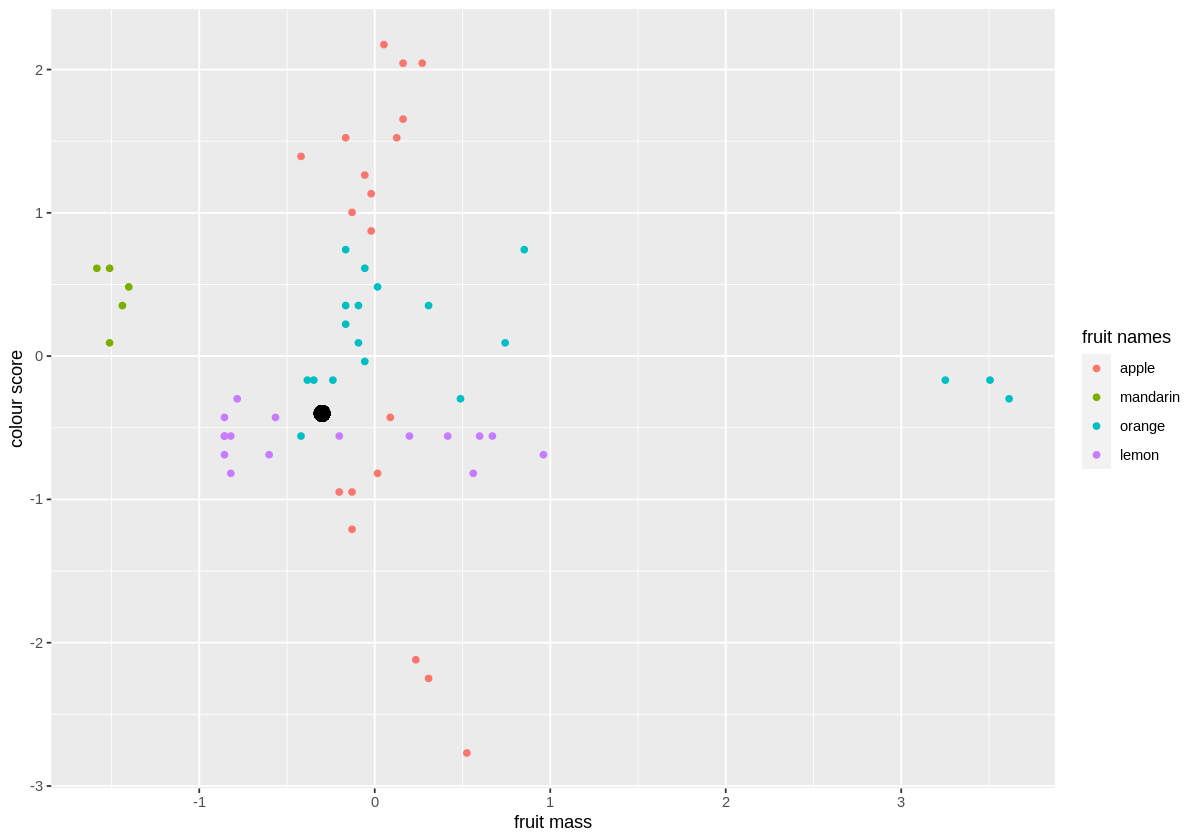

In [52]:
options(repr.plot.width = 10, repr.plot.height = 7) # you can change the plot size 

fruit_plot + 
    geom_point(aes(x = -0.3, y = -0.4), color = "black", size = 4)

**Question 1.12**
<br> {points: 1}

Now do K-nearest neighbours classification again with the same data set, same K, and same new observation. However, this time, let's use **all the columns in the dataset as predictors (except for the categorical `fruit_label` and `fruit_subtype` variables).**

We have provided the `new_fruit_all` dataframe below, which encodes the predictors for our new observation. Your job is to use K-nearest neighbours to predict the class of this point. You can reuse the model specification you created earlier. 

*Assign your answer (the output of `predict`) to an object called `fruit_all_predicted`.*

In [60]:
#This is the new observation to predict class label for
new_fruit_all <- tibble(mass = 150, 
                            color_score = 0.73, 
                            height = 10,
                            width = 6)

fruit_data_recipe_3 <- recipe(fruit_name ~ mass + color_score + height + width, data = fruit_data) |>                        step_scale(all_predictors()) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

fruit_fit_all <- workflow() |>
          add_recipe(fruit_data_recipe_3) |>
          add_model(knn_spec) |>
          fit(data = fruit_data)

fruit_all_predicted <- predict(fruit_fit_all, new_fruit_all)

fruit_all_predicted

.pred_class
<fct>
lemon


In [61]:
test_1.12()

Test passed 🌈
Test passed 🥇
[1] "Success!"


**Question 1.13** 
<br> {points: 3}

Did your second classification on the same data set with the same K change the prediction? If so, why do you think this happened?

it changed from orange to lemon when their is more data availble to take in as predictors there will be more calculated and the weight of each predictor effects it different 


## 2. Wheat Seed Dataset

X-ray images can be used to analyze and sort seeds. In [this data set](https://archive.ics.uci.edu/ml/datasets/seeds), we have 7 measurements from x-ray images from 3 varieties of wheat seeds (Kama, Rosa and Canadian). 

**Question 2.0**
<br> {points: 3}

Let's use `tidymodels` to perform K-nearest neighbours to classify the wheat variety of seeds. The data set is available here: https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt. **Download the data set directly from this URL using the `read_table2()` function**, which is helpful when the columns are separated by one or more white spaces.

The seven measurements were taken below for each wheat kernel:
1. area A, 
2. perimeter P, 
3. compactness C = 4*pi*A/P^2, 
4. length of kernel, 
5. width of kernel, 
6. asymmetry coefficient 
7. length of kernel groove. 

The last column in the data set is the variety label. The mapping for the numbers to varieties is listed below:

- 1 == Kama
- 2 == Rosa
- 3 == Canadian

Use `tidymodels` with this data to perform K-nearest neighbours to classify the wheat variety of a new seed we measure with the given observed measurements (from an x-ray image) listed above. Specify that we want $K = 5$ neighbors to perform the classification. Don't forget to perform any necessary preprocessing!

*Assign your answer to an object called `seed_predict`.*

Hints: 
- `colnames()` can be used to specify the column names of a data frame.
- the wheat variety column appears numerical, but you want it to be treated as categorical for this analysis, thus `as_factor()` might be helpful.

In [67]:
# Set the seed. Don't remove this!
set.seed(9999) 

#This is the new observation to predict
new_seed <- tibble(area = 12.1,
                        perimeter = 14.2,
                        compactness = 0.9,
                        length = 4.9,
                        width = 2.8,
                        asymmetry_coefficient = 3.0, 
                        groove_length = 5.1)

data_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"

col_names <- c("area", "perimeter", "compactness", "length", "width", "asymmetry_coefficient", "groove_length", "variety")
seed_data <- read_table2(data_url, col_names = col_names)

seed_data <- seed_data |>
  mutate(variety = as_factor(variety))

seed_data_recipe <- recipe(variety ~ area + perimeter + compactness + length + width + asymmetry_coefficient + groove_length, data = seed_data) |>                       
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

seed_fit_all <- workflow() |>
          add_recipe(seed_data_recipe) |>
          add_model(knn_spec) |>
          fit(data = seed_data)

seed_predict <- predict(seed_fit_all, new_seed)

seed_predict



── Column specification ────────────────────────────────────────────────────────
cols(
  area = col_double(),
  perimeter = col_double(),
  compactness = col_double(),
  length = col_double(),
  width = col_double(),
  asymmetry_coefficient = col_double(),
  groove_length = col_double(),
  variety = col_double()
)



.pred_class
<fct>
3


**Question 2.1** Multiple Choice:
<br> {points: 1}

What is classification of the `new_seed` observation?

A. Kama

B. Rosa

C. Canadian

*Assign your answer to an object called `answer2.1`. Make sure your answer is in uppercase and is surrounded by quotation marks (e.g. `"F"`).*


In [68]:
answer2.1 <- "C"

In [69]:
test_2.1()

Test passed 🌈
Test passed 😀
[1] "Success!"


In [70]:
source("cleanup.R")